In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("project03.ipynb")

# Project 3: Movie Classification

In this project, you will build a classifier that guesses whether a movie is a comedy or a thriller, using only the number of times words appear in the movies's screenplay.  By the end of the project, you should know how to:

1. Build a $k-$nearest-neighbors classifier.
2. Test a classifier on data.

## Logistics

**Deadline.** This project is due by the end of the Final Asessment period. Refer to due dates in Canvas / Gradescope for specific dates and times.

**Rules.** You are welcome to discuss questions with other students, but don't share the answers. If someone asks you for the answer, resist! Instead, you can demonstrate how you would solve a similar problem.

**Support.** You are not alone! Come to office hours, post on EdSTEM, and talk to your classmates. If you want to ask about the details of your solution to a problem, send an email or private EdSTEM post to your instructor and they will respond. If you're ever feeling overwhelmed or don't know how to make progress, email your instructor for help! 

**Tests.** The tests that are given are **not comprehensive** and passing the tests for a question **does not** mean that you answered the question correctly. Tests usually only check that your table has the correct column labels. However, more tests will be applied to verify the correctness of your submission in order to assign your final score, so be careful and check your work! You might want to create your own checks along the way to see if your answers make sense. Additionally, before you submit, make sure that none of your cells take a very long time to run (several minutes).

**Free Response Questions:** Make sure that you put the answers to the written questions in the indicated cell we provide.

**Advice.** Develop your answers incrementally. To perform a complicated table manipulation, break it up into steps, perform each step on a different line, give a new name to each result, and check that each intermediate result is what you expect. You can add any additional names or functions you want to the provided cells. Make sure that you are using distinct and meaningful variable names throughout the notebook. Along that line, **DO NOT** reuse the variable names that we use when we grade your answers. For example, in Question 1.1 we ask you to assign an answer to `expected_row_sum`. Do not reassign the variable name `expected_row_sum` to anything else in your notebook, otherwise there is the chance that our tests grade against what `expected_row_sum` was reassigned to.

You **never** have to use just one line in this project or any others. Use intermediate variables and multiple lines as much as you would like!  

To get started, load `datascience`, `numpy`, and `plots`.

In [2]:
import numpy as np
import math
from datascience import *

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## 1. The Dataset

In this project, we are exploring movie screenplays. We'll be trying to predict each movie's genre from the text of its screenplay. In particular, we have compiled a list of 5,000 words that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

Run the cell below to read the `movies` table. 

In [3]:
movies = Table.read_table('movies.csv')
movies.where("Title", "wild wild west").select(0, 1, 2, 3, 4, 14, 49, 1042, 4004)

Title,Year,Rating,Genre,# Words,breez,england,it,bravo
wild wild west,1999,4.3,comedy,3446,0,0,0.0212635,0


The above cell prints a few columns of the row for the comedy movie *Wild Wild West*.  The movie contains 3446 words. The word "it" appears 74 times, as it makes up 

$$\frac{74}{3446} \approx 0.021364$$ 

of the words in the movie. The word "england" doesn't appear at all.
This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format. In this project, we will investigate whether this representation is sufficient to build an accurate genre classifier.

All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

**Note:** All movies in our dataset have their titles lower-cased.

In [4]:
title_index = movies.index_by('Title')

def row_for_title(title):
    """Return the row for a title, similar to the following 
       expression (but faster) movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

#row_for_title('the terminator')

For example, the fastest way to find the frequency of "none" in the movie **The Terminator** is to access the `'none'` item from its row. Check the original table to see if this worked for you.

In [5]:
row_for_title('the terminator').item('none')

0.0009633911368015

### Question 1.1.
Set `expected_row_sum` to the number that you __expect__ will result from summing all proportions in each row, excluding the first five columns.

<!--
BEGIN QUESTION
name: q1_1
manual: false
-->

In [6]:
# Set row_sum to a number that's the (approximate) sum of each row of word proportions.
expected_row_sum = 1

In [7]:
grader.check("q1_1")

q1_1 results: All test cases passed!

This dataset was extracted from [a dataset from Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). After transforming the dataset (e.g., converting the words to lowercase, removing the naughty words, and converting the counts to frequencies), we created this new dataset containing the frequency of 5000 common words in each movie.

In [8]:
print('Words with frequencies:', movies.drop(np.arange(5)).num_columns) 
print('Movies with genres:', movies.num_rows)

/opt/conda/lib/python3.9/site-packages/datascience/tables.py:1252: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if i not in exclude and c not in exclude])


Words with frequencies: 5000
Movies with genres: 370


### 1.1. Word Stemming

The columns other than "Title", "Year", "Rating", "Genre", and "# Words" in the `movies` table are all words that appear in some of the movies in our dataset.  These words have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie. This is a common technique used in machine learning and natural language processing.

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table that will let you see examples of unstemmed versions of each stemmed word.  Run the code below to load it.

In [9]:
# Just run this cell
vocab_mapping = Table.read_table('stem.csv')
stemmed = np.take(movies.labels, np.arange(3, len(movies.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1110))

Stem,Word
bond,bonding
bone,bone
bone,boning
bone,bones
bonu,bonus
book,bookings
book,books
book,booking
book,booked
book,book


#### Question 1.1.1.
Assign `stemmed_message` to the stemmed version of the word "vegetables".

<!--
BEGIN QUESTION
name: q1_1_1
manual: false
-->

In [10]:
stemmed_message = vocab_table.where("Word", "vegetable").column("Stem").item(0)
stemmed_message

'veget'

In [11]:
grader.check("q1_1_1")

q1_1_1 results: All test cases passed!

#### Question 1.1.2.
What stem in the dataset has the most words that are shortened to it? Assign `most_stem` to that stem.

<!--
BEGIN QUESTION
name: q1_1_2
manual: false
-->

In [12]:
most_stem = vocab_table.group("Stem").sort("count", descending=True).column("Stem").item(0)
most_stem

'gener'

In [13]:
grader.check("q1_1_2")

q1_1_2 results: All test cases passed!

#### Question 1.1.3.
What is the longest word in the dataset whose stem wasn't shortened? Assign that to `longest_uncut`. Break ties alphabetically from Z to A (so if your options are "albatross" or "batman", you should pick "batman").

<!--
BEGIN QUESTION
name: q1_1_3
manual: false
-->

In [14]:
# In our solution, we found it useful to first add columns with
# the length of the word and the length of the stem,
# and then to add a column with the difference between those lengths.
# What will the difference be if the word is not shortened?
tbl_with_lens = vocab_table.with_columns(
    "Word length", vocab_table.apply(len, "Word"),
    "Stem length", vocab_table.apply(len, "Stem")
)
differences = tbl_with_lens.column(2) - tbl_with_lens.column(3)
tbl_with_dif = tbl_with_lens.with_column("Difference", differences)

sorted_table = tbl_with_dif.where("Difference", 0).sort("Word length", descending=True)
longest_length = sorted_table.column("Word length").item(0)
longest_uncut = sorted_table.where("Word length", longest_length).sort("Word", descending=True).column(0).item(0)
longest_uncut

'misunderstand'

In [15]:
grader.check("q1_1_3")

q1_1_3 results: All test cases passed!

### 1.2. Exploratory Data Analysis: Linear Regression

Let's explore our dataset before trying to build a classifier. To start, we'll look at the relationship between words in proportions. 

The first association we'll investigate is the association between the proportion of words that are "outer" and the proportion of words that are "space". 

As usual, we'll investigate our data visually before performing any numerical analysis.

Run the cell below to plot a scatter diagram of space proportions vs outer proportions and to create the `outer_space` table.

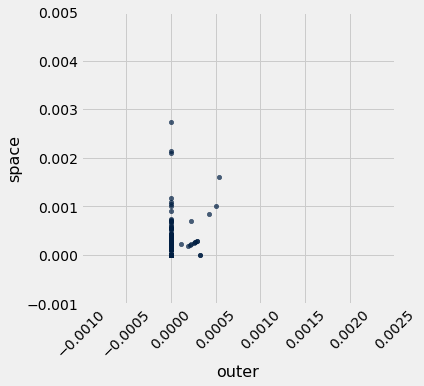

In [16]:
# Just run this cell
outer_space = movies.select("outer", "space")
outer_space.scatter("outer", "space")
plots.axis([-0.001, 0.0025, -0.001, 0.005]);
plots.xticks(rotation=45);

#### Question 1.2.1.
Looking at that chart it is difficult to see if there is an association. Calculate the correlation coefficient for the association between proportion of words that are "outer" and the proportion of words that are "space" for every movie in the dataset, and assign it to `outer_space_r`.

<!--
BEGIN QUESTION
name: q1_2_1
manual: false
-->

In [17]:
# Our solution took multiple lines. 
# These two arrays should make your code cleaner.
outer = movies.column("outer")
space = movies.column("space")

def standard_units(nums):
    return (nums - np.mean(nums)) / np.std(nums)

outer_su = standard_units(outer)
space_su = standard_units(space)
outer_space_r = np.mean(outer_su * space_su)

outer_space_r

0.2829527833012746

In [18]:
grader.check("q1_2_1")

q1_2_1 results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Question 1.2.2.
Choose two *different* words in the dataset with a correlation higher than 0.2 or smaller than -0.2 that are not *outer* and *space* and plot a scatter plot with a line of best fit for them. The code to plot the scatter plot and line of best fit is given for you, you just need to calculate the correct values to `r`, `slope` and `intercept`.

**Hint 1:** It's easier to think of words with a positive correlation, (i.e. words that are often mentioned together).

**Hint 2:** Try to think of common phrases or idioms.

<!--
BEGIN QUESTION
name: q1_2_2
manual: true
-->

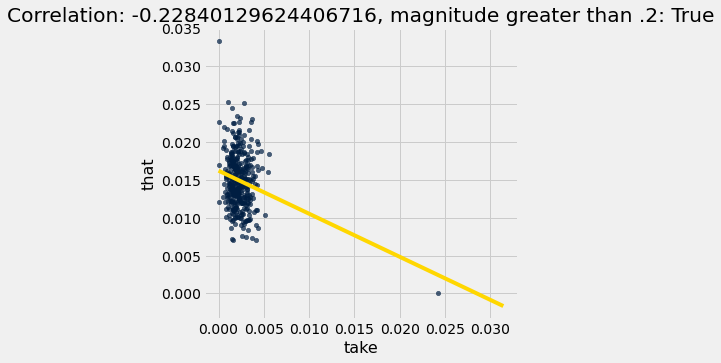

In [19]:
word_x = "take"
word_y = "that"

# These arrays should make your code cleaner
arr_x = movies.column(word_x)
arr_y = movies.column(word_y)

x_su = standard_units(arr_x)
y_su = standard_units(arr_y)

r = np.mean(x_su * y_su)

slope = r * np.std(arr_y) / np.std(arr_x)
intercept = np.mean(arr_y) - slope * np.mean(arr_x)

# Don't change these lines of code
movies.scatter(word_x, word_y)
max_x = max(movies.column(word_x))
plots.title(f"Correlation: {r}, magnitude greater than .2: {abs(r) >= 0.2}")
plots.plot([0, max_x * 1.3], [intercept, intercept + slope * (max_x*1.3)], color = 'gold');

<!-- END QUESTION -->



### 1.3. Splitting the Dataset
We're going to use our `movies` dataset for two purposes.

1. First, we want to **train** movie genre classifiers.
2. Second, we want to **test** the performance of our classifiers.

Hence, we need two different datasets: *training* and *test*.

The purpose of a classifier is to classify unseen data that is similar to the training data. Therefore, we must ensure that there are no movies that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the top for training and the rest for test. 

Run the code below (without changing it) to separate the datasets into two tables.

In [20]:
# Here we have defined the proportion of our data
# that we want to designate for training as 17/20ths
# of our total dataset.  3/20ths of the data is
# reserved for testing.

training_proportion = 17/20

num_movies = movies.num_rows
num_train = int(num_movies * training_proportion)
num_test = num_movies - num_train

train_movies = movies.take(np.arange(num_train))
test_movies = movies.take(np.arange(num_train, num_movies))

print("Training: ",   train_movies.num_rows, ";",
      "Test: ",       test_movies.num_rows)

Training:  314 ; Test:  56


<!-- BEGIN QUESTION -->

#### Question 1.3.1.
Draw a horizontal bar chart with two bars that show the proportion of Comedy movies in each dataset. Complete the function `comedy_proportion` first; it should help you create the bar chart.

<!--
BEGIN QUESTION
name: q1_3_1
manual: true
-->

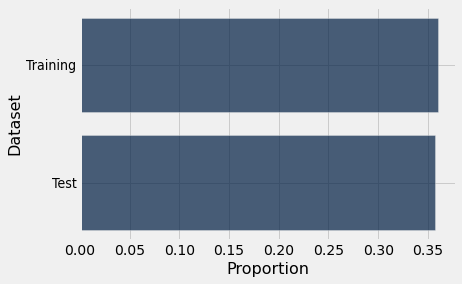

In [21]:

def comedy_proportion(table):
# Return the proportion of movies in a table that have the Comedy genre.
    return sum(table.column("Genre") == "comedy") / table.num_rows
# The staff solution took multiple lines. Start by creating a table.
# If you get stuck, think about what sort of table you need for barh to work ..."""; 

bar_table = Table().with_columns(
    "Dataset", make_array("Training", "Test"),
    "Proportion", make_array(comedy_proportion(train_movies), comedy_proportion(test_movies))
)
bar_table.barh("Dataset")

<!-- END QUESTION -->



## 2. K-Nearest Neighbors - A Guided Example

K-Nearest Neighbors (k-NN) is a classification algorithm.  Given some numerical **attributes** (also called **features**) of an unseen example, it decides whether that example belongs to one or the other of two categories based on its similarity to previously seen examples. Predicting the category of an example is called **labeling**, and the predicted category is also called a **label**.

An attribute (feature) we have about each movie is *the proportion of times a particular word appears in the movies*, and the labels are two movie genres: comedy and thriller.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_movies` table.

To build understanding, we're going to visualize the algorithm instead of just describing it.

### 2.1. Classifying a Movie

In k-NN, we classify a movie by finding the `k` movies in the **training set** that are most similar according to the features we choose. We call those movies with similar features the **nearest neighbors**.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each movie.  The features we will use are the proportions of the words "water" and "feel" in the movie.  Taking the movie **Monty Python and the Holy Grail** (in the test set), 0.000804074 of its words are "water" and 0.0010721 are "feel". This movie appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  We will say that the **distance** between two movies is the straight-line distance between them when we plot their features in a scatter diagram. 

This distance is called the Euclidean distance, whose formula is 

$$\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}.$$

For example, in the movie **Clerks.** (in the training set), 0.00016293 of all the words in the movie are "water" and 0.00154786 are "feel".  Its distance from **Monty Python and the Holy Grail** on this 2-word feature set is 

$$\sqrt{(0.000804074 - 0.000162933)^2 + (0.0010721 - 0.00154786)^2} \approx 0.000798379.$$  

**Note:** If we included more or different features, the distance could be different.

A third movie, **The Avengers** (in the training set), is 0 "water" and 0.00103173 "feel".

The function below creates a plot to display the "water" and "feel" features of a test movie and some training movies. As you can see in the result, **Monty Python and the Holy Grail** is more similar to **Clerks.** than to the **The Avengers** based on these features, which is makes sense as both movies are comedy movies, while **The Avengers** is a thriller.


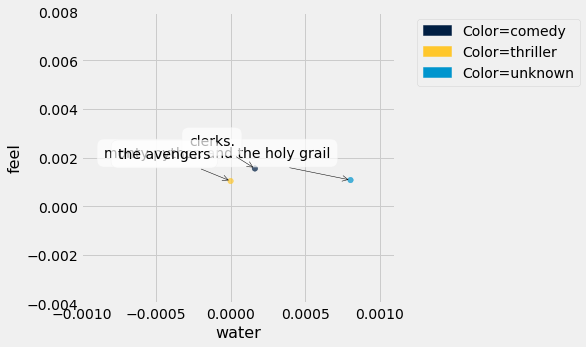

In [22]:
# Just run this cell.
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = row_for_title(test_movie)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['unknown'],
            'Title',   [test_movie]
        )
    for movie in training_movies:
        row = row_for_title(movie)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), movie])
    distances.scatter(x_feature, y_feature, group='Color', labels='Title', s=30)
    
training = ["clerks.", "the avengers"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel")
plots.axis([-0.001, 0.0011, -0.004, 0.008]);

#### Question 2.1.1.
Compute the Euclidean distance (defined in the section above) between the two movies, **Monty Python and the Holy Grail** and **The Avengers**, using the `water` and `feel` features only.  Assign it the name `one_distance`.

**Note:** If you have a row, you can use `item` to get a value from a column by its name.  For example, if `r` is a row, then `r.item("Genre")` is the value in column `"Genre"` in row `r`.

**Hint:** Remember the function `row_for_title`, redefined for you below.

<!--
BEGIN QUESTION
name: q2_1_1
manual: false
-->

In [23]:
title_index = movies.index_by('Title')
python = row_for_title("monty python and the holy grail")
avengers = row_for_title("the avengers")

python_array = make_array(python.item("water"), python.item("feel"))
avengers_array = make_array(avengers.item("water"), avengers.item("feel"))

one_distance = np.sqrt(sum((python_array - avengers_array)**2))
one_distance

0.0008050869157478146

In [24]:
grader.check("q2_1_1")

q2_1_1 results: All test cases passed!

Below, we've added a third training movie, **The Silence of the Lambs**. Before, the point closest to **Monty Python and the Holy Grail** was **Clerks.**, a comedy movie. However, now the closest point is **The Silence of the Lambs**, a thriller movie.

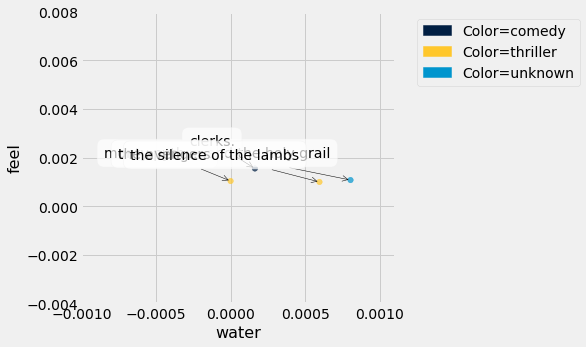

In [25]:
training = ["clerks.", "the avengers", "the silence of the lambs"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel") 
plots.axis([-0.001, 0.0011, -0.004, 0.008]);

#### Question 2.1.2.
Complete the function `distance_two_features` that computes the Euclidean distance between any two movies, using two features. The last two lines call your function to show that **Monty Python and the Holy Grail** is closer to **The Silence of the Lambs** than it is to **Clerks.**. 

<!--
BEGIN QUESTION
name: q2_1_2
manual: false
-->

In [26]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two movies with titles title0 and title1.
       Only the features named x_feature and y_feature are used when computing 
       the distance.
    """
    row0 = row_for_title(title0)
    row1 = row_for_title(title1)
    
    arr0 = make_array(row0.item(x_feature), row0.item(y_feature))
    arr1 = make_array(row1.item(x_feature), row1.item(y_feature))

    return np.sqrt(sum((arr0 - arr1)**2))

for movie in make_array("clerks.", "the silence of the lambs"):
    movie_distance = distance_two_features(movie, "monty python and the holy grail", "water", "feel")
    
print(movie, 'distance:\t', movie_distance)

the silence of the lambs distance:	 0.00022256314855564847


In [27]:
grader.check("q2_1_2")

q2_1_2 results: All test cases passed!

#### Question 2.1.3.
Define the function `distance_from_python` so that it works as described in its documentation.

**Note:** Your solution should not use arithmetic operations directly. Instead, it should make use of existing functionality above.

<!--
BEGIN QUESTION
name: q2_1_3
manual: false
-->

In [28]:
def distance_from_python(title):
    """The distance between the given movie and "monty python and the holy grail",
       based on the features "water" and "feel".
       
       This function takes a single argument: title: A string, the name of a movie.
    """
    return distance_two_features(title, "monty python and the holy grail", "water", "feel")

In [29]:
grader.check("q2_1_3")

q2_1_3 results: All test cases passed!

#### Question 2.1.4.
Using the features `"water"` and `"feel"`, what are the names and genres of the 5 movies in the **training set** closest to **Monty Python and the Holy Grail**?  To answer this question, make a table named `close_movies` containing those 5 movies with columns `"Title"`, `"Genre"`, `"water"`, and `"feel"`, as well as a column called `"distance from python"` that contains the distance from **Monty Python and the Holy Grail**.  The table should be **sorted in ascending order by `distance from python`**.

<!--
BEGIN QUESTION
name: q2_1_4
manual: false
-->

In [30]:
# The instructor solution took multiple lines.
distance_table = train_movies.select("Title", "Genre", "water", "feel").with_column("distance from python", train_movies.apply(distance_from_python, "Title"))
close_movies = distance_table.sort("distance from python").take(np.arange(5))
close_movies

Title,Genre,water,feel,distance from python
alien,thriller,0.00070922,0.00124113,0.000193831
tomorrow never dies,thriller,0.000888889,0.000888889,0.00020189
the silence of the lambs,thriller,0.000595948,0.000993246,0.000222563
innerspace,comedy,0.000522193,0.00104439,0.00028324
some like it hot,comedy,0.000528541,0.000951374,0.00030082


In [31]:
grader.check("q2_1_4")

q2_1_4 results: All test cases passed!

#### Question 2.1.5.
Next, we'll clasify **Monty Python and the Holy Grail** based on the genres of the closest movies. 

To do so, define the function `most_common` so that it works as described in its documentation below.

<!--
BEGIN QUESTION
name: q2_1_5
manual: false
-->

In [32]:
def most_common(label, table):
    """The most common element in a column of a table.
    
       This function takes two arguments:
           label: The label of a column, a string.
           table: A table.

       It returns the most common value in that column of that table.
       In case of a tie, it returns any one of the most common values
    """
    return table.group("Genre").sort("count", descending=True).column(0).item(0)

# Calling most_common on your table of 5 nearest neighbors classifies
# "monty python and the holy grail" as a thriller movie, 3 votes to 2.
most_common('Genre', close_movies)

'thriller'

In [33]:
grader.check("q2_1_5")

q2_1_5 results: All test cases passed!

Congratulations are in order$-$you've classified your first movie! However, we can see that the classifier doesn't work too well since it categorized **Monty Python and the Holy Grail** as a thriller movie (unless you count the thrilling holy hand grenade scene). 

Let's see if we can do better.

## 3. Features

Now, we're going to extend our classifier to consider more than two features at a time.

Euclidean distance still makes sense with more than two features. For `n` different features, we compute the difference between corresponding feature values for two movies, square each of the `n`  differences, sum up the resulting numbers, and take the square root of the sum.

### Question 3.1.
Write a function called `distance` to compute the Euclidean distance between two **arrays** of **numerical** features (e.g. arrays of the proportions of times that different words appear). The function should be able to calculate the Euclidean distance between two arrays of arbitrary (but equal) length. 

Next, use the function you just defined to compute the distance between the first and second movie in the training set *using all of the features*.  (Remember that the first five columns of your tables are not features.)

**Note:** To convert rows to arrays, use `np.array`. For example, if `t` was a table, `np.array(t.row(0))` converts row 0 of `t` into an array.

**Note:** If you're working offline: Depending on the versions of your packages, you may need to convert rows to arrays using the following instead: `np.array(list(t.row(0))`

<!--
BEGIN QUESTION
name: q3_1
manual: false
-->

In [34]:
def distance(features_array1, features_array2):
    """The Euclidean distance between two arrays of feature values."""
    return np.sqrt(sum((features_array1 - features_array2)**2))

cleaned_table = train_movies.drop(np.arange(5))
distance_first_to_second = distance(np.array(cleaned_table.row(0)), np.array(cleaned_table.row(1)))
distance_first_to_second

0.033354468908813176

In [35]:
grader.check("q3_1")

q3_1 results: All test cases passed!

## 3.1. Creating Your Own Feature Set

Unfortunately, using all of the features has some downsides.  One clear downside is *computational* $-$ computing Euclidean distances just takes a long time when we have lots of features.  You might have noticed that in the last question!

So we're going to select just 20.  We'd like to choose features that are very *discriminative*. That is, features which lead us to correctly classify as much of the test set as possible.  This process of choosing features that will make a classifier work well is sometimes called *feature selection*, or, more broadly, *feature engineering*.

### Question 3.1.1.
In this question, we will help you get started on selecting more effective features for distinguishing comedy from thriller movies. The plot below (generated for you) shows the average number of times each word occurs in a comedy movie on the horizontal axis and the average number of times it occurs in an thriller movie on the vertical axis.


**Note:** The line graphed is the line of best fit, not $y=x$.

![alt text](wordplot.png "Title")

The following questions ask you to interpret the plot above. For each question, select one of the following choices and assign its number to the provided name.

    1. The word is common in both comedy and thriller movies 
    2. The word is uncommon in comedy movies and common in thriller movies
    3. The word is common in comedy movies and uncommon in thriller movies
    4. The word is uncommon in both comedy and thriller movies
    5. It is not possible to say from the plot 
    
What properties does a word in the bottom left corner of the plot have? Your answer should be a single integer from 1 to 5, corresponding to the correct statement from the choices above.

<!--
BEGIN QUESTION
name: q3_1_1
manual: false
-->

In [36]:
bottom_left = 4

In [37]:
grader.check("q3_1_1")

q3_1_1 results: All test cases passed!

### Question 3.1.2.
What properties does a word in the bottom right corner have?

<!--
BEGIN QUESTION
name: q3_1_2
manual: false
-->

In [38]:
bottom_right = 3

In [39]:
grader.check("q3_1_2")

q3_1_2 results: All test cases passed!

### Question 3.1.3.
What properties does a word in the top right corner have?

<!--
BEGIN QUESTION
name: q3_1_3
manual: false
-->

In [40]:
top_right = 1

In [41]:
grader.check("q3_1_3")

q3_1_3 results: All test cases passed!

### Question 3.1.4.
What properties does a word in the top left corner have?

<!--
BEGIN QUESTION
name: q3_1_4
manual: false
-->

In [42]:
top_left = 2

In [43]:
grader.check("q3_1_4")

q3_1_4 results: All test cases passed!

### Question 3.1.5.
If we see a movie with a lot of words that are common for comedy movies but uncommon for thriller movies, what would be a reasonable guess about the genre of the movie? 

Assign `movie_genre` to the number corresponding to your answer:
    
    1. It is a thriller movie.
    2. It is a comedy movie.
    
<!--
BEGIN QUESTION
name: q3_1_5
manual: false
-->

In [44]:
movie_genre_guess = 2

In [45]:
grader.check("q3_1_5")

q3_1_5 results: All test cases passed!

### Question 3.1.6.
Using the plot above, make an array of at least 10 common words that you think might let you distinguish between comedy and thriller movies. Make sure to choose words that are frequent enough that every movie contains at least one of them. Don't just choose the most frequent words, though$-$you can do much better.

You might want to come back to this question later to improve your list, once you've seen how to evaluate your classifier.  

<!--
BEGIN QUESTION
name: q3_1_6
manual: false
-->

In [46]:
# Set my_20_features to an array of 20 features (strings that are column labels)
my_features = make_array('i',    'the',  'to',  'a',    'it', 
                         'and',  'that', 'of',  'your', 'what', 
                         'in',   'me',   'is',  'do',   'thi',
                         'love', 'dead', 'fun', 'laugh', 'cop',
                         'scream', 'joke', 'fight', 'cry', 'good'
)

# Select the 20 features of interest from both the train and test sets
train_my_features = train_movies.select(my_features)
test_my_features = test_movies.select(my_features)

In [47]:
grader.check("q3_1_6")

q3_1_6 results: All test cases passed!

This test makes sure that you have chosen words such that at least one appears in each movie. If you can't find words that satisfy this test just through intuition, try writing code to print out the titles of movies that do not contain any words from your list, then look at the words they do contain.

<!-- BEGIN QUESTION -->

### Question 3.1.7.
In two sentences or less, describe how you selected your features.

<!--
BEGIN QUESTION
name: q3_1_7
manual: true
-->

I selected my features by picking words that were common but had strong connotations to them. For example, love has strong positive connotations, making it seem like it would come from a comedy, while dead has strong negative connotations more closely associated with thrillers.

<!-- END QUESTION -->



Next, let's classify the first movie from our test set using these features.  You can examine the movie by running the cells below. Do you think it will be classified correctly?

In [48]:
print("Movie:")
test_movies.take(0).select('Title', 'Genre').show()
print("Features:")
test_my_features.take(0).show()

Movie:


Title,Genre
new nightmare,thriller


Features:


i,the,to,a,it,and,that,of,your,what,in,me,is,do,thi,love,dead,fun,laugh,cop,scream,joke,fight,cry,good
0.0222384,0.0317171,0.0185928,0.0211447,0.0273423,0.0156763,0.0120306,0.0102078,0.00874954,0.0113015,0.0145826,0.00911411,0.0127598,0.00546847,0.00619759,0.00109369,0.000364564,0,0,0.000729129,0,0,0.000364564,0,0.00182282


As before, we want to look for the movies in the training set that are most like our test movie.  We will calculate the Euclidean distances from the test movie (using `my_features`) to all movies in the training set.  You could do this with a `for` loop, but to make it computationally faster, we have provided a function, `fast_distances`, to do this for you.  Read its documentation to make sure you understand what it does.

You don't need to understand the code in its body unless you want to.

In [49]:
# Just run this cell to define fast_distances
def fast_distances(test_row, train_table):
    """Return an array of the distances between test_row and each row in train_rows.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test movie (e.g., test_my_features.row(0)).
      train_table: A table of features (for example, the whole
        table train_my_features)."""
    assert train_table.num_columns < 50, "Make sure you're not using all the features of the movies table."
    counts_matrix = np.asmatrix(train_table.columns).transpose()
    diff = np.tile(np.array(list(test_row)), [counts_matrix.shape[0], 1]) - counts_matrix
    np.random.seed(0) # For tie breaking purposes
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    eps = np.random.uniform(size=distances.shape)*1e-10 #Noise for tie break
    distances = distances + eps
    return distances

### Question 3.1.8.
Use the `fast_distances` function provided above to compute the distance from the first movie in the test set to all the movies in the training set, **using your set of features**.  Make a new table called `genre_and_distances` with one row for each movie in the training set and two columns:

* The `"Genre"` of the training movie
* The `"Distance"` from the first movie in the test set 

Ensure that `genre_and_distances` is **sorted in ascending order by distance to the first test movie**.

<!--
BEGIN QUESTION
name: q3_1_8
manual: false
-->

In [50]:
# The instructor solution took multiple lines of code.
distances = fast_distances(test_my_features.row(0), train_my_features)
genre_and_distances = train_movies.select(3).with_column("Distance", distances).sort("Distance")
genre_and_distances

Genre,Distance
thriller,0.0122514
thriller,0.0132599
thriller,0.0136097
thriller,0.0142722
thriller,0.0144616
thriller,0.0145521
thriller,0.0146265
thriller,0.0147175
comedy,0.0150011
thriller,0.0152681


In [51]:
grader.check("q3_1_8")

q3_1_8 results: All test cases passed!

### Question 3.1.9.
Now compute the 7-nearest neighbors classification of the first movie in the test set.  That is, decide on its genre by finding the most common genre among its 7 nearest neighbors in the training set, according to the distances you've calculated.  Then check whether your classifier chose the right genre.  (Depending on the features you chose, your classifier might not get this movie right, and that's okay.)

<!--
BEGIN QUESTION
name: q3_1_9
manual: false
-->

In [52]:
# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = genre_and_distances.take(np.arange(7)).group("Genre").sort("count", descending=True).column(0).item(0)

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first movie in the test set.
my_assigned_genre_was_correct = test_movies.row(0).item(3) == my_assigned_genre

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

The assigned genre, thriller, was correct.


In [53]:
grader.check("q3_1_9")

q3_1_9 results: All test cases passed!

## 3.2. A Classifier Function

Now we can write a single function that encapsulates the whole process of classification.

### Question 3.2.1.
Write a function called `classify`.  It should take the following four arguments:

* A row of features for a movie to classify (e.g., `test_my_features.row(0)`).
* A table with a column for each feature (e.g., `train_my_features`).
* An array of classes (e.g. the labels "comedy" or "thriller") that has as many items as the previous table has rows, and in the same order.
* `k`, the number of neighbors to use in classification.

It should return the class a `k`-nearest neighbor classifier picks for the given row of features (the string `'comedy'` or the string `'thriller'`).

<!--
BEGIN QUESTION
name: q3_2_1
manual: false
-->

In [54]:
def classify(test_row, train_rows, train_labels, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_rows)
    genre_and_distances = Table().with_columns("Genre", train_labels, "Distance", distances).sort("Distance")
    return genre_and_distances.take(np.arange(k)).group("Genre").sort("count", descending=True).column(0).item(0)

In [55]:
grader.check("q3_2_1")

q3_2_1 results: All test cases passed!

### Question 3.2.2.
Assign `tron_genre` to the genre predicted by your classifier for the movie "tron" in the test set, using **13 neighbors** and using your 20 features.

<!--
BEGIN QUESTION
name: q3_2_2
manual: false
-->

In [56]:
tron_features = test_movies.where("Title", "tron").select(my_features).row(0)
tron_genre = classify(tron_features, train_my_features, train_movies.column(3), 13)
tron_genre

'thriller'

In [57]:
grader.check("q3_2_2")

q3_2_2 results: All test cases passed!

Finally, when we evaluate our classifier, it will be useful to have a classification function that is specialized to use a fixed training set and a fixed value of `k`.

### Question 3.2.3.
Create a classification function that takes as its argument a row containing your 20 features and classifies that row using the 13-nearest neighbors algorithm with `train_20` as its training set.

<!--
BEGIN QUESTION
name: q3_2_3
manual: false
-->

In [58]:
def classify_feature_row(row):
    return classify(row, train_my_features, train_movies.column(3), 13)

# When you're done, this should produce 'Thriller' or 'Comedy'.
classify_feature_row(test_my_features.row(0))

'thriller'

In [59]:
grader.check("q3_2_3")

q3_2_3 results: All test cases passed!

## 3.3. Evaluating Your Classifier

Now that it's easy to use the classifier, let's see how accurate it is on the whole test set.

### Question 3.3.1.
Use `classify_feature_row` and `apply` to classify every movie in the test set.  Assign these guesses as an array to `test_guesses`, **then**, compute the proportion of correct classifications. 

<!--
BEGIN QUESTION
name: q3_3_1
manual: false
-->

In [60]:
test_guesses = test_my_features.apply(classify_feature_row)
proportion_correct = sum(test_movies.column(3) == test_guesses) / test_movies.num_rows
proportion_correct

0.625

In [61]:
grader.check("q3_3_1")

q3_3_1 results: All test cases passed!

### Question 3.3.2.
An important part of evaluating your classifiers is figuring out where they make mistakes. Assign the name `test_movie_correctness` to a table with three columns, `'Title'`, `'Genre'`, and `'Was correct'`. The last column should contain `True` or `False` depending on whether or not the movie was classified correctly.

<!--
BEGIN QUESTION
name: q3_3_2
manual: false
-->

In [62]:
# Feel free to use multiple lines of code
# but make sure to assign test_movie_correctness to the proper table!
correct = test_movies.column(3) == test_guesses
test_movie_correctness = Table().with_columns("Title", test_movies.column(0), "Genre", test_movies.column(3), "Was correct", correct)
test_movie_correctness.sort('Was correct', descending = True).show(5)

Title,Genre,Was correct
new nightmare,thriller,True
smoke,comedy,True
godzilla,thriller,True
rear window,thriller,True
jason goes to hell: the final friday,thriller,True


In [63]:
grader.check("q3_3_2")

q3_3_2 results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 3.3.3.
Do you see a pattern in the types of movies your classifier misclassifies? In two sentences or less, describe any patterns you see in the results or any other interesting findings from the table above. If you need some help, try looking up the movies that your classifier got wrong on Wikipedia.

<!--
BEGIN QUESTION
name: q3_3_3
manual: true
-->

The classifier misclassifies thrillers and comedies equally, but it seems that a lot of the movies it gets wrong are older movies in the 1930s-1950s. Most of the movies misclassified were released before 2000.

<!-- END QUESTION -->



At this point, you've gone through one cycle of classifier design.  Let's summarize the steps:

1. From available data, select test and training sets.
2. Choose an algorithm you're going to use for classification.
3. Identify some features.
4. Define a classifier function using your features and the training set.
5. Evaluate its performance (the proportion of correct classifications) on the test set.

## 4. Explorations
Now that you know how to evaluate a classifier, it's time to build a better one.

<!-- BEGIN QUESTION -->

### Question 4.1.
Develop a classifier with better test-set accuracy than `classify_feature_row`.  Your new function should have the same arguments as `classify_feature_row` and return a classification.  Name it `another_classifier`. Then, check your accuracy using code from earlier.

You can use more or different features, or you can try different values of `k`. (Of course, you still have to use `train_movies` as your training set!) 

**Make sure you don't reassign any previously used variables here**, such as `proportion_correct` from the previous question.

<!--
BEGIN QUESTION
name: q4_1
manual: true
-->

In [64]:
# To start you off, here's a list of possibly-useful features
# Feel free to add or change this array to improve your classifier
new_features = make_array("laugh", "marri", "dead", "heart", "cop", 
                          'love', 'fun', 'scream', 'joke', 'fight', 
                          'cry', 'terrifi', 'break', 'kill', 'monster')
train_new = train_movies.select(new_features)
test_new = test_movies.select(new_features)

def another_classifier(row):
    return classify(row, train_new, train_movies.column(3), 13)

test_guesses = test_new.apply(another_classifier)
proportion_correct = sum(test_movies.column(3) == test_guesses) / test_movies.num_rows
print(proportion_correct)

correct = test_movies.column(3) == test_guesses
test_movie_correctness = Table().with_columns("Title", test_movies.column(0), "Genre", test_movies.column(3), "Was correct", correct)
test_movie_correctness.sort('Was correct', descending = False).show()

0.7321428571428571


Title,Genre,Was correct
smoke,comedy,False
mystery of the wax museum,thriller,False
rear window,thriller,False
fast times at ridgemont high,comedy,False
the fifth element,thriller,False
storytelling,comedy,False
hannibal,thriller,False
his girl friday,comedy,False
misery,thriller,False
tron,thriller,False


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 4.2.
Do you see a pattern in the mistakes your new classifier makes? What about in the improvement from your first classifier to the second one? Describe in two sentences or less.

**Hint:** You may not be able to see a pattern.

<!--
BEGIN QUESTION
name: q4_2
manual: true
-->

There wasn't really much of a pattern. The movies are all from different time periods and the classifier didn't misclassify a genre more than another one.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 4.3.
Briefly describe what you tried to improve your classifier. 

<!--
BEGIN QUESTION
name: q4_3
manual: true
-->

I tried to use more specific words that were more likely to strongly appear in one genre than another one.

<!-- END QUESTION -->



## Congratulations

You have completed your own large scale case study using classification.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [65]:
grader.check_all()

q1_1 results: All test cases passed!

q1_1_1 results: All test cases passed!

q1_1_2 results: All test cases passed!

q1_1_3 results: All test cases passed!

q1_2_1 results: All test cases passed!

q2_1_1 results: All test cases passed!

q2_1_2 results: All test cases passed!

q2_1_3 results: All test cases passed!

q2_1_4 results: All test cases passed!

q2_1_5 results: All test cases passed!

q3_1 results: All test cases passed!

q3_1_1 results: All test cases passed!

q3_1_2 results: All test cases passed!

q3_1_3 results: All test cases passed!

q3_1_4 results: All test cases passed!

q3_1_5 results: All test cases passed!

q3_1_6 results: All test cases passed!

q3_1_8 results: All test cases passed!

q3_1_9 results: All test cases passed!

q3_2_1 results: All test cases passed!

q3_2_2 results: All test cases passed!

q3_2_3 results: All test cases passed!

q3_3_1 results: All test cases passed!

q3_3_2 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

When done exporting, download the .zip file by finding it in the file browswer on the left side of the screen, then right-click and select **Download**. You'll submit this .zip file for the assignment in Canvas to Gradescope for grading.

In [66]:
# Save your notebook first, then run this cell to export your submission.
grader.export()